<a href="https://colab.research.google.com/github/remko66/eredivision/blob/master/lungs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import cv2
import numpy as np
from keras import Model
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/My Drive/development/machinelearningcourse.io/health/data' . -r

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dd='/content/drive/My Drive/development/machinelearningcourse.io/health/'

def select_image_by_category(image_dir='/content/data/chest_xray/train/test', image_count_per_category=3):
    classes = os.listdir(image_dir)
    if '.DS_Store' in classes:
        classes.remove('.DS_Store')
    class_count = len(classes)
    image_file_paths = {}
    for i in range(class_count):
        subdir_path = image_dir + "/" + classes[i]
        subdir_files = os.listdir(subdir_path)
        subdir_file_count = len(subdir_files)
        subdir_file_mem = {}
        subdir_file_index = -1
        image_file_paths[classes[i]] = []
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count - 1)
            subdir_file_mem[subdir_file_index] = 1
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path + "/" + subdir_file_name
            image_file_paths[classes[i]].append(subdir_file_path)
    return image_file_paths,classes

def prediction(pic,model):
    p=preprocess_input(pic)
    a=[]
    a.append(p)

    res=model.predict(np.asarray(a))[0]
    print(res)
    g=np.argmax(res)
    result="Normal"
    if g==1:
        result="Pheumonia"
    return result


In [12]:

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)



train_generator = train_datagen.flow_from_directory(
        '/content/data/chest_xray/train',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical'
        )


Found 5216 images belonging to 2 classes.


In [13]:

base=InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)


# add a global spatial average pooling layer
x = base.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(100, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy')

#model.load_weights("lungs.h5")


a=model.fit_generator(
        train_generator,
        steps_per_epoch=80,
        epochs=25,
        verbose=1)
model.save_weights("lungs.h5")


Epoch 1/25
80/80 [==============================] - 121s 2s/step - loss: 0.3727
Epoch 2/25
80/80 [==============================] - 119s 1s/step - loss: 0.2401
Epoch 3/25
80/80 [==============================] - 118s 1s/step - loss: 0.1916
Epoch 4/25
80/80 [==============================] - 118s 1s/step - loss: 0.1841
Epoch 5/25
80/80 [==============================] - 119s 1s/step - loss: 0.1647
Epoch 6/25
80/80 [==============================] - 118s 1s/step - loss: 0.1578
Epoch 7/25
80/80 [==============================] - 118s 1s/step - loss: 0.1489
Epoch 8/25
80/80 [==============================] - 118s 1s/step - loss: 0.1812
Epoch 9/25
80/80 [==============================] - 118s 1s/step - loss: 0.1714
Epoch 10/25
80/80 [==============================] - 118s 1s/step - loss: 0.1403
Epoch 11/25
80/80 [==============================] - 119s 1s/step - loss: 0.1465
Epoch 12/25
80/80 [==============================] - 118s 1s/step - loss: 0.1429
Epoch 13/25
80/80 [==================

[0.17808056 0.8219194 ]
real PNEUMONIA predicted Pheumonia
[2.589903e-04 9.997410e-01]
real PNEUMONIA predicted Pheumonia
[0.95934045 0.04065954]
real PNEUMONIA predicted Normal
[0.93638074 0.06361926]
real NORMAL predicted Normal
[0.96252084 0.03747919]
real NORMAL predicted Normal
[0.39848647 0.60151356]
real NORMAL predicted Pheumonia


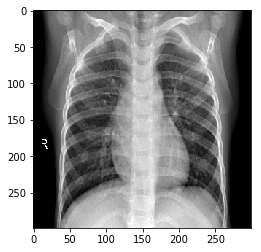

In [20]:


images,classes=select_image_by_category(image_dir='/content/data/chest_xray/test', image_count_per_category=3)

for i in range(len(classes)):
    for k in images[classes[i]]:
        pic=cv2.imread(k,cv2.IMREAD_COLOR)
        pic = cv2.resize(pic, (299, 299))
        result=prediction(pic,model)
        plt.imshow(pic)
        print("real",classes[i],'predicted',result)

plt.show()